# Import all kind of stuff

In [16]:
import sys

import numpy as np
from numpy.typing import NDArray

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

from scipy.special import jv

local = "/Users/oliver/Documents/doctoral-thesis/.utilities/"
remote = "/Users/oliver/Documents/p5control-bluefors-evaluation/"
textwidth = 4.25279  # in
textheight = 6.85173 # in

sys.path.append(local)
sys.path.append(remote)

plt.style.use(f'{local}thesisstyle.mplstyle')

from thesislayout import get_figure, theory_layout

from cpd5 import get_color, get_colors
from cpd5 import (
    seeblau120,
    seeblau100,
    seeblau80,
    seeblau65,
    seeblau35,
    seeblau20,
)
from cpd5 import (
    seegrau120,
    seegrau100,
    seegrau80,
    seegrau65,
    seegrau35,
    seegrau20,
)

from theory.utilities.constants import k_B_meV, G_0_muS, e, h
from theory.utilities.types import NDArray64

from theory.utilities.functions import bin_y_over_x, oversample

# theory
from theory.models.bcs import Delta_meV_of_T
from theory.models.bcs import get_I_nA as get_I_nA_bcs
from theory.models.tg import get_I_pat_nA as get_I_nA_tg

from matplotlib_inline.backend_inline import InlineBackend
InlineBackend.print_figure_kwargs = {"bbox_inches": None, "pad_inches": 0.0}
%config InlineBackend.print_figure_kwargs = {'bbox_inches': None, 'pad_inches': 0.0}
%config InlineBackend.figure_format = "retina"   # or "png"
%config InlineBackend.rc = {"figure.dpi": 450}   # choose a value you like

%matplotlib inline

In [17]:
figsize = 1.3, 1
textwidth / 3

1.4175966666666666

In [18]:
data = np.genfromtxt("PG.csv", delimiter=",")
PG_x = data[:, 0]
PG_y = data[:, 1]
mask = np.where(PG_x <= 4.8, True, False)
PG_x = PG_x[mask]
PG_y = PG_y[mask]

data = np.genfromtxt("Gx.csv", delimiter=",")
Gx_x = data[:, 0]
Gx_y = data[:, 1]
Gx_y = (Gx_y - 1) / 0.75
Gx_x -= np.min(Gx_x)

data = np.genfromtxt("GV.csv", delimiter=",")
GV_x = data[:, 0]
GV_y = data[:, 1]
GV_y = np.flip(GV_y)
# GV_x = np.flip(GV_x)

GV_x = GV_x[460:]
GV_y = GV_y[460:]

GV_x -= np.min(GV_x)
# GV_x /= 0.8

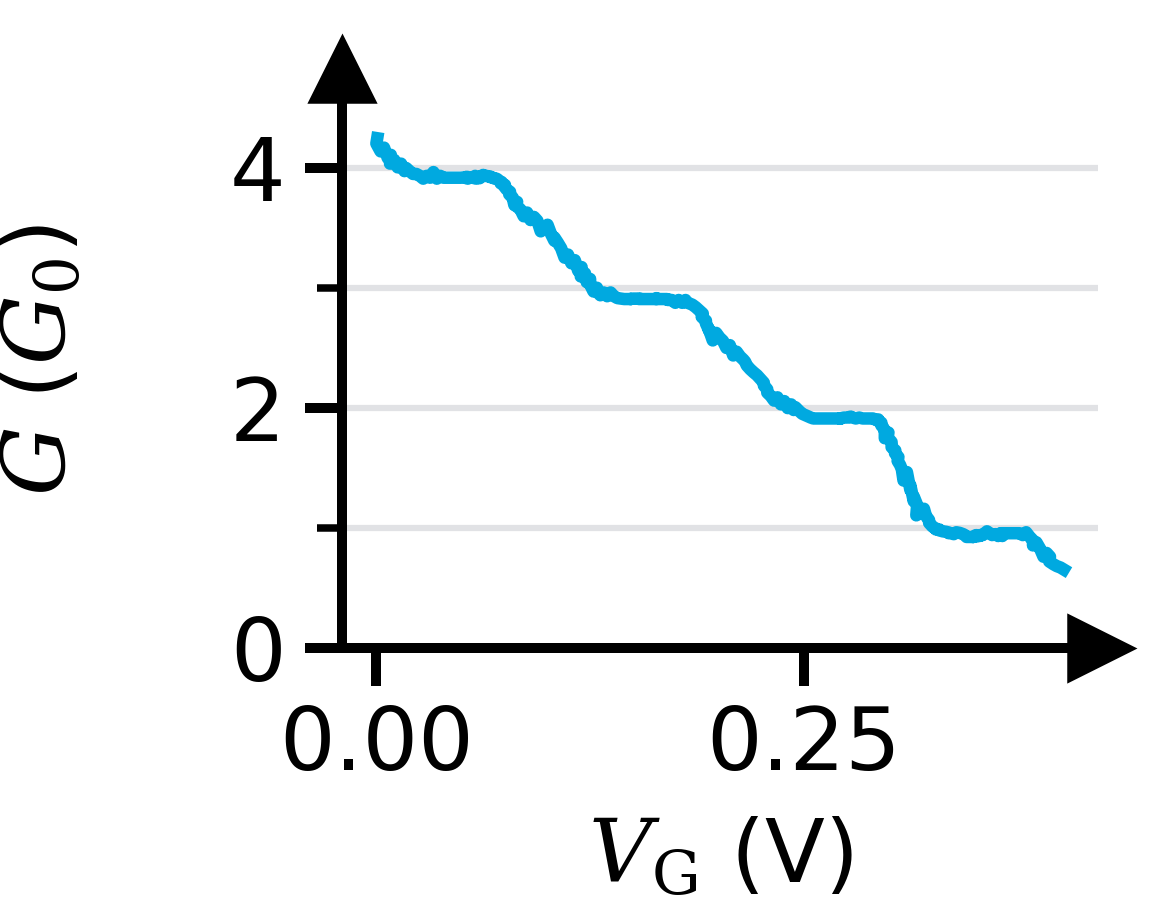

In [19]:
fig, ax = get_figure(figsize=figsize, subfigure=True)
ax.plot(
    GV_x,
    GV_y,
    "-",
    color=seeblau100,
)

ax.set_ylim((0, 4.8))
ax.set_yticks([0, 2, 4])
ax.yaxis.set_minor_locator(MultipleLocator(1))

ax.grid(
    visible=True, color=seegrau20, which="both", linewidth=0.5, linestyle="-", axis="y"
)

xlabel = "$V_\\mathrm{G}$ (V)"
ylabel = "$G$ ($G_0$)"
title = "GV"

theory_layout(fig, ax, title, xlabel, ylabel)

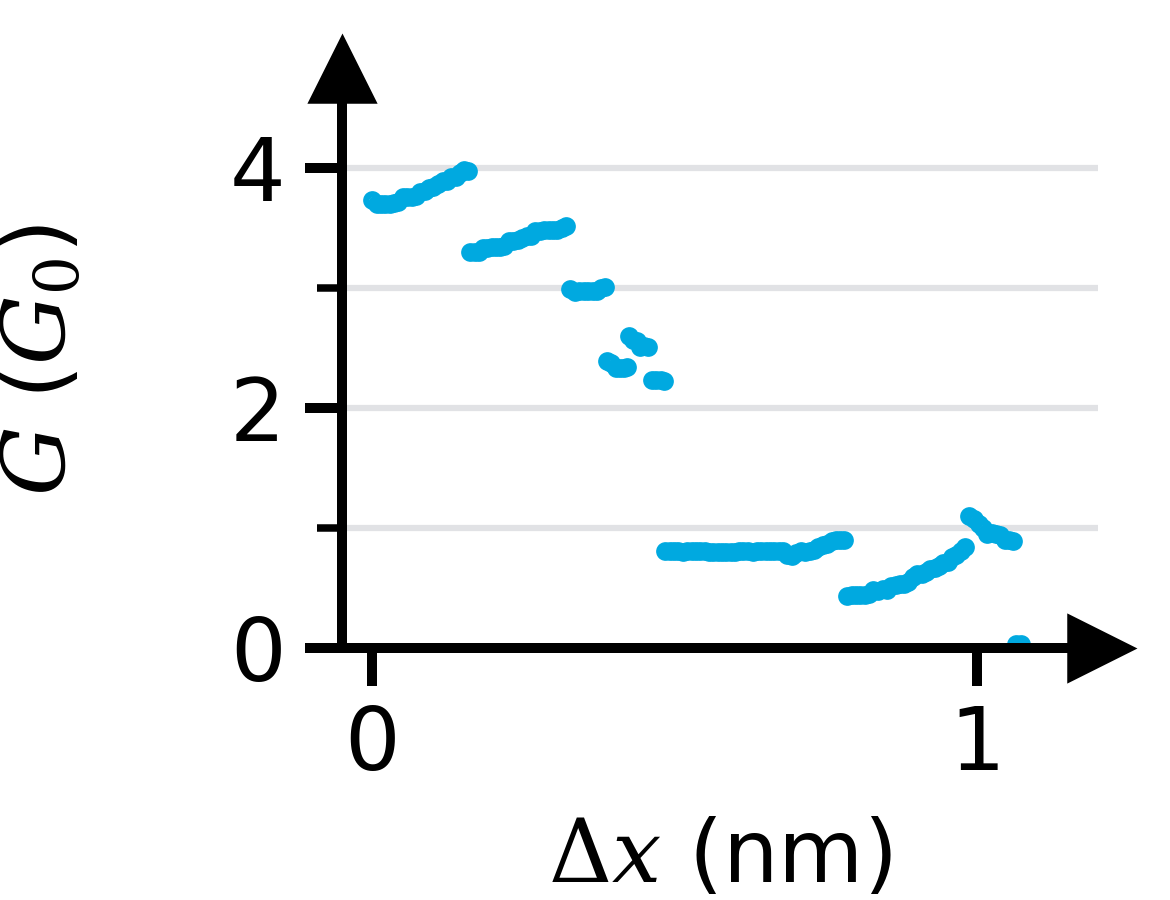

In [20]:
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

fig, ax = get_figure(figsize=figsize, subfigure=True)
ax.plot(
    Gx_x,
    Gx_y,
    ".",
    color=seeblau100,
)

ax.set_ylim((0, 4.8))
ax.set_yticks([0, 2, 4])
ax.yaxis.set_minor_locator(MultipleLocator(1))

ax.set_xlim([-0.05, 1.2])
ax.set_xticks([0, 1.0])

ax.grid(
    visible=True, color=seegrau20, which="both", linewidth=0.5, linestyle="-", axis="y"
)

xlabel = "$\\Delta x$ (nm)"
ylabel = "$G$ ($G_0$)"
title = "Gx"

theory_layout(fig, ax, title, xlabel, ylabel)

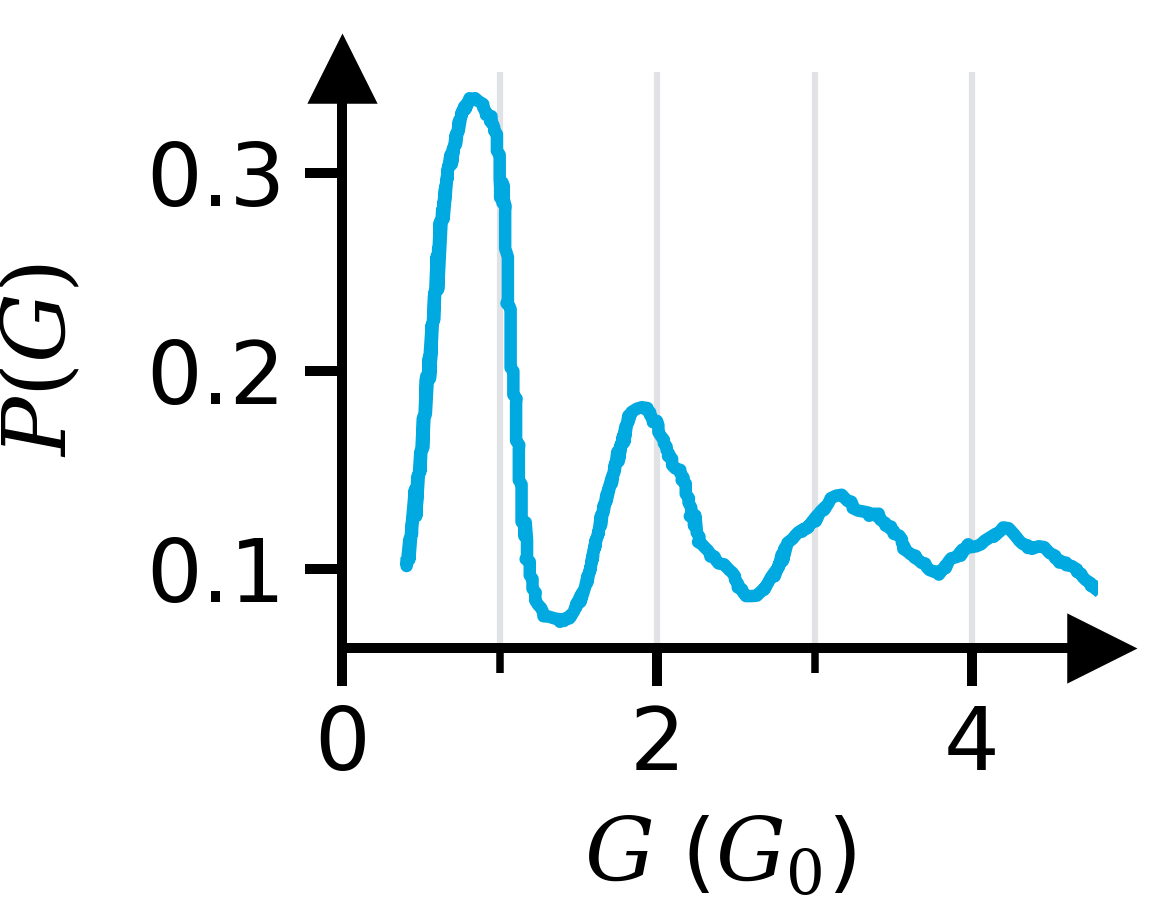

In [21]:
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

fig, ax = get_figure(figsize=figsize, subfigure=True)
ax.plot(
    PG_x,
    PG_y,
    "-",
    color=seeblau100,
)

ax.set_xlim((0, 4.8))
ax.set_xticks([0, 2, 4])
ax.xaxis.set_minor_locator(MultipleLocator(1))

ax.grid(
    visible=True, color=seegrau20, which="both", linewidth=0.5, linestyle="-", axis="x"
)

xlabel = "$G$ ($G_0$)"
ylabel = "$P(G)$"
title = "PG"

theory_layout(fig, ax, title, xlabel, ylabel)

# Micro-wave

In [22]:
Delta_0_mV = 0.18

V_0 = 0.5
V_0_mV = V_0 * Delta_0_mV
V_0_V = V_0_mV * 1e-3
A_0 = 0.5
A_0_mV = A_0 * Delta_0_mV
A_0_V = A_0_mV * 1e-3
nu_GHz = 10
nu_Hz = nu_GHz * 1e9
omega = 2 * np.pi * nu_Hz
t_0_ps = 1e3 / nu_GHz
t_0_s = t_0_ps * 1e-12

t_ps = np.linspace(0, 540, 1001)  # ps
t_s = t_ps * 1e-12
dt_s = t_s[1] - t_s[0]

V_mV = V_0_mV + A_0_mV * np.cos(omega * t_s)
V_V = V_mV * 1e-3
V = V_mV / Delta_0_mV

m = 1
q = m * e / h
alpha_0 = q * A_0_V / nu_Hz

phi = q * np.cumsum(V_V) * dt_s * 2 * np.pi  # dimensionless (radians)
phi_0 = q * V_0_V * t_s * 2 * np.pi
phi_a = alpha_0 * np.sin(omega * t_s)

U = np.exp(-1j * phi)
U_0 = np.exp(-1j * phi_0)
U_a = np.exp(-1j * phi_a)

A = np.array([0.5, 1, 1.5, 2.0])
n0 = np.linspace(0, 13, 14)
n1 = np.linspace(0, 13, 131)
j0 = np.zeros((A.shape[0], n0.shape[0]))
j1 = np.zeros((A.shape[0], n1.shape[0]))

A_mV = A * Delta_0_mV
A_V = A_mV * 1e-3
alpha = q * A_V / nu_Hz
for i, a in enumerate(alpha):
    j0[i, :] = jv(n0, a)
    j1[i, :] = jv(n1, a)

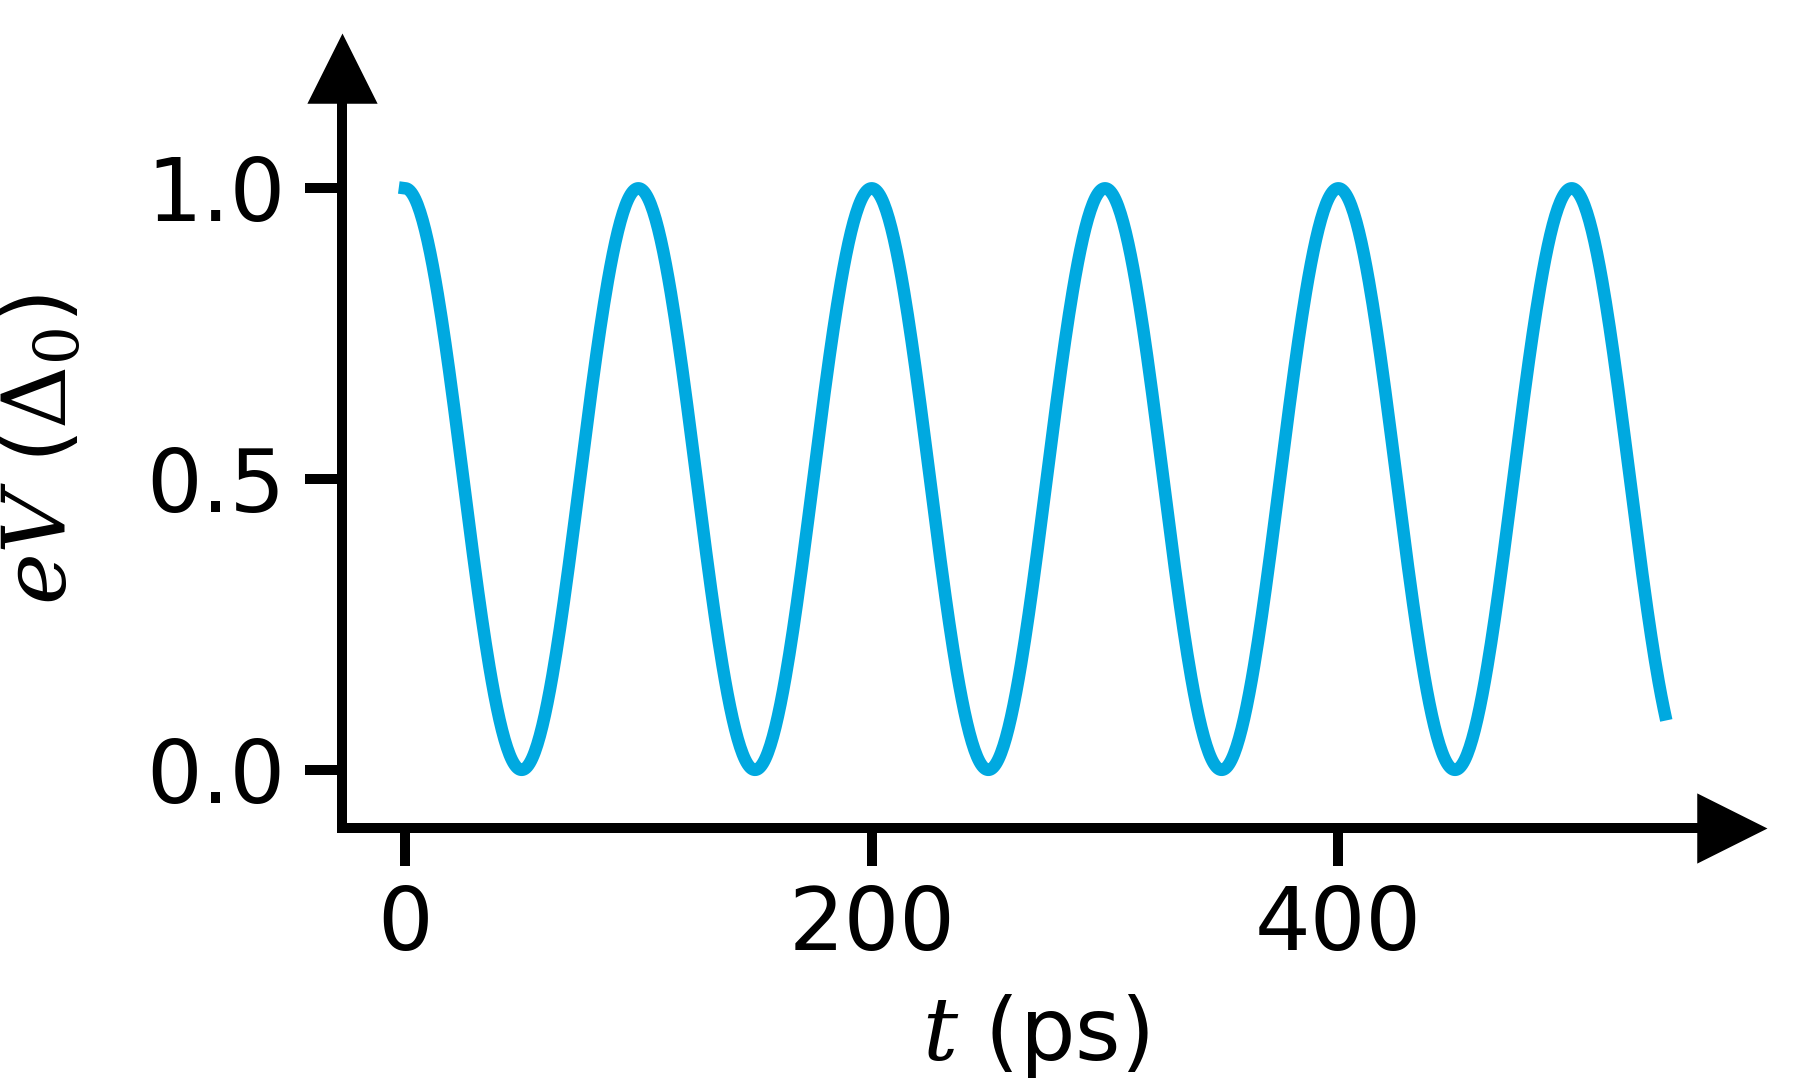

In [23]:
fig, ax = get_figure(figsize=(2.0, 1.2), subfigure=True)

ax.plot(
    t_ps,
    V,
    color=seeblau100,
)

ax.set_ylim(-0.1, 1.2)

xlabel = "$t$ (ps)"
ylabel = "$eV$ ($\\Delta_0$)"
title = "mw-V"

theory_layout(fig, ax, title, xlabel, ylabel)

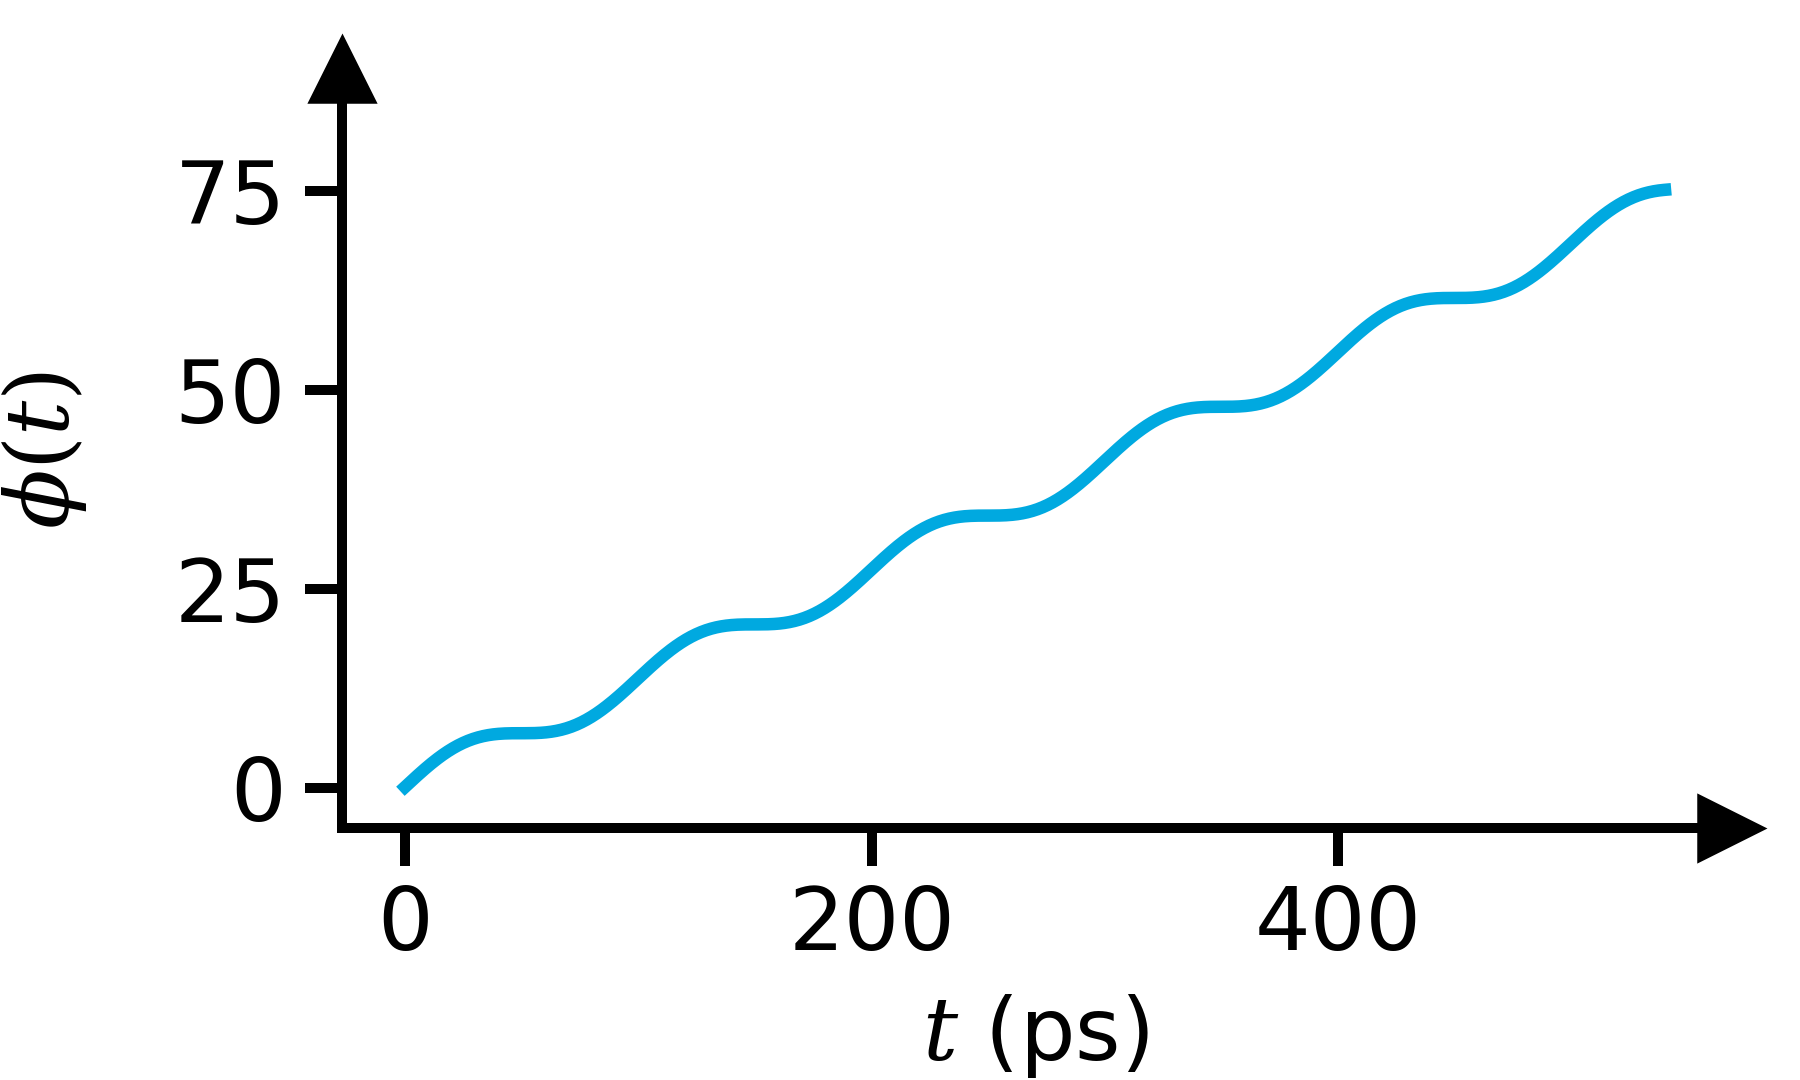

In [24]:
fig, ax = get_figure(figsize=(2.0, 1.2), subfigure=True)

ax.plot(
    t_ps,
    phi,
    color=seeblau100,
)

ax.set_ylim(-5, 90)

xlabel = "$t$ (ps)"
ylabel = "$\\phi(t)$"
title = "mw-phi"

theory_layout(fig, ax, title, xlabel, ylabel)

Substituting symbol \Re from STIXGeneral
Substituting symbol \Re from STIXGeneral
Substituting symbol \Re from STIXGeneral


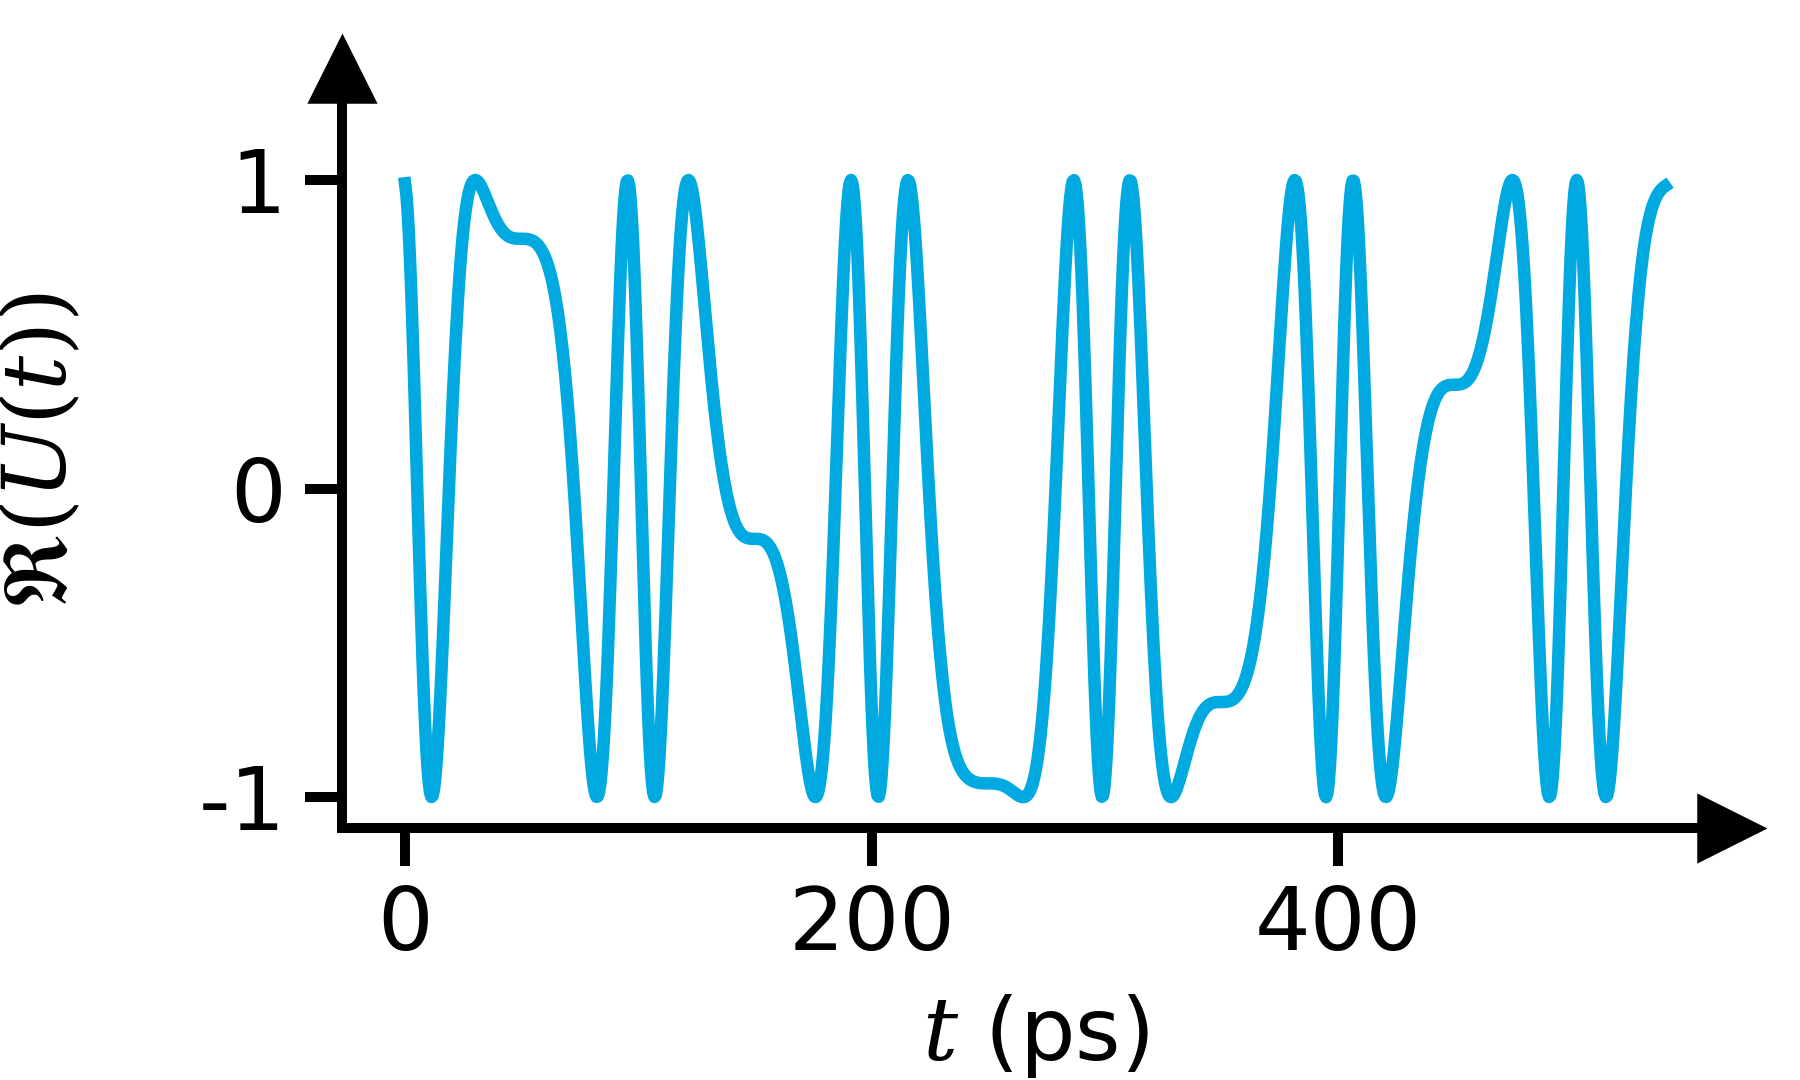

In [25]:
fig, ax = get_figure(figsize=(2.0, 1.2), subfigure=True)

ax.plot(
    t_ps,
    np.real(U),
    color=seeblau100,
)

ax.set_ylim(-1.1, 1.35)

xlabel = "$t$ (ps)"
ylabel = "$\\Re\\,\\!(U(t))$"
title = "mw-ReU"

theory_layout(fig, ax, title, xlabel, ylabel)

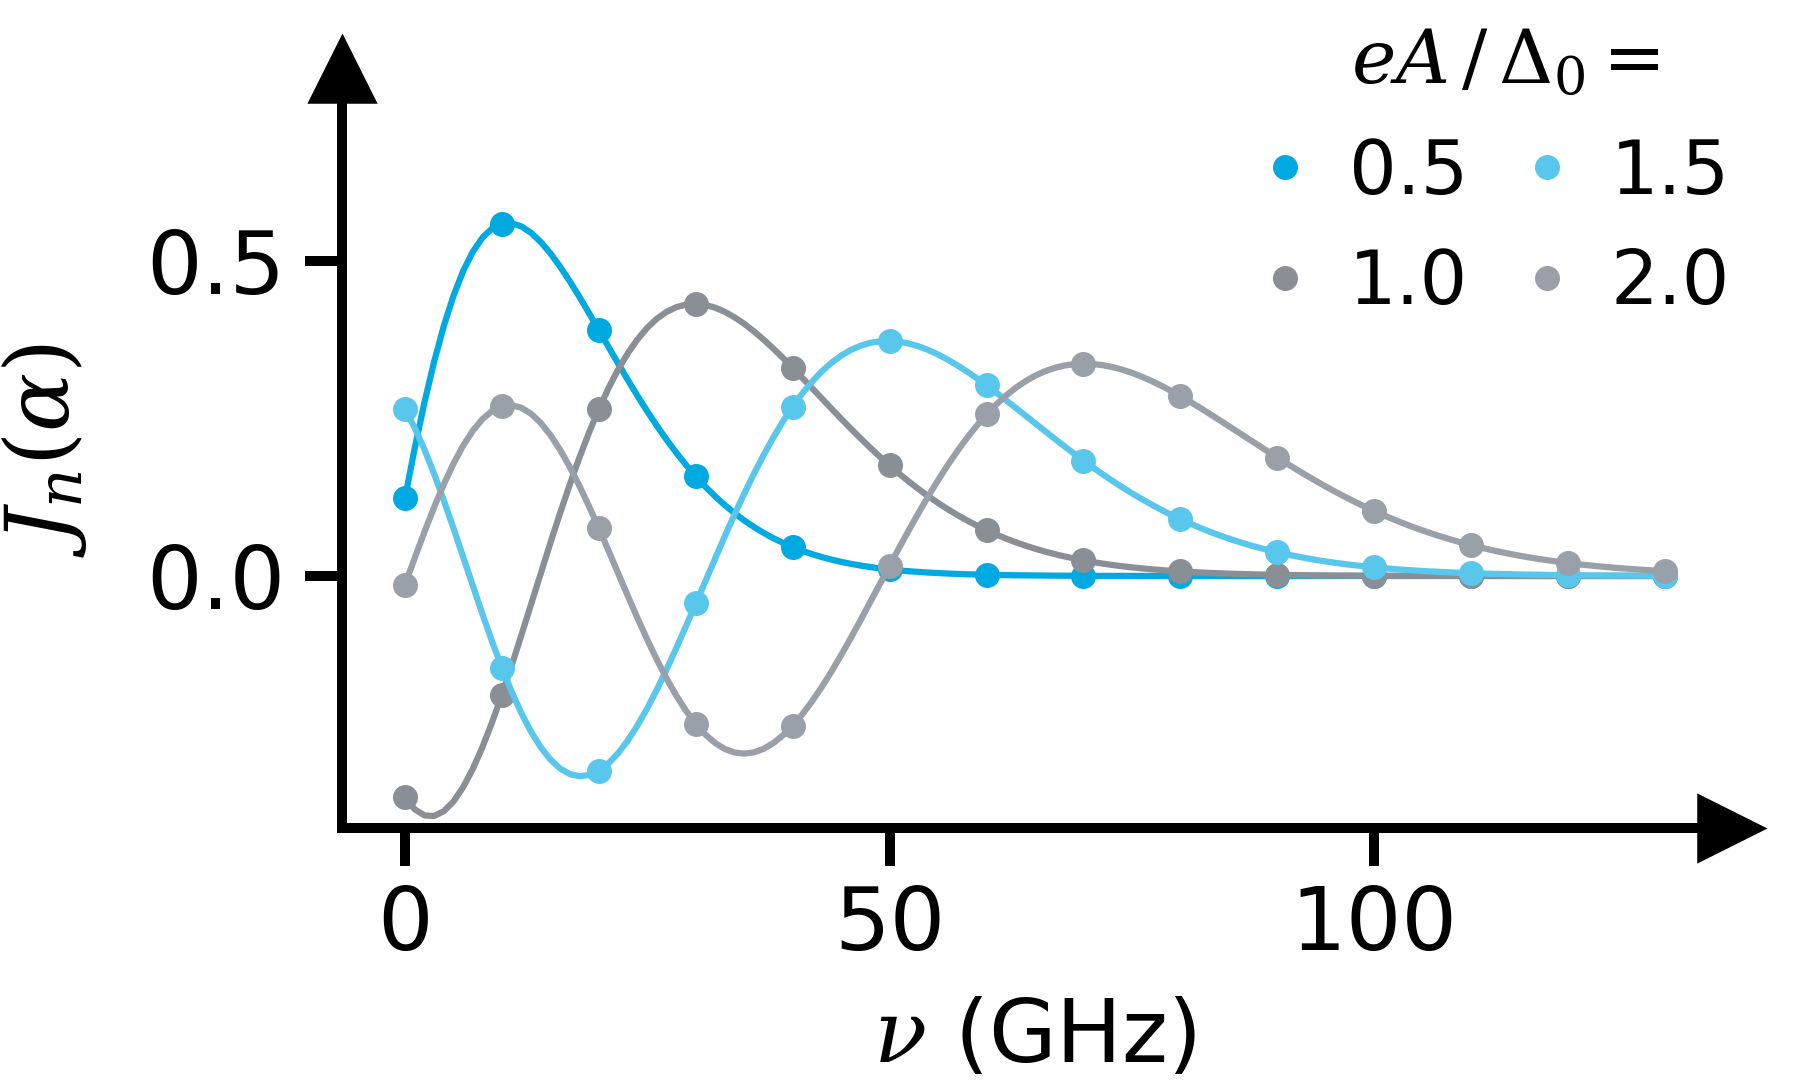

In [26]:
fig, ax = get_figure(figsize=(2.0, 1.2), subfigure=True)


color = [seeblau100, seegrau80, seeblau65, seegrau65, seeblau35, seegrau35]

for i, a in enumerate(alpha):
    ax.plot(
        n0 * nu_GHz,
        j0[i, :],
        ".",
        ms=2,
        zorder=i + 4,
        color=color[i],
        label=f"{A[i]}",
    )
    ax.plot(
        n1 * nu_GHz,
        j1[i, :],
        "-",
        lw=0.5,
        zorder=i + 4,
        color=color[i],
    )

# ax.xaxis.set_minor_locator(MultipleLocator(10))
# ax.grid(
#     visible=True,
#     color=seegrau20,
#     which="both",
#     linewidth=0.5,
#     linestyle="-",
#     axis="x",
#     zorder=0,
# )
ax.legend(
    title="$eA\\,/\\,\\Delta_0 = $",
    handlelength=0.1,
    loc="upper right",
    bbox_to_anchor=(1.05, 1.15),
    frameon=False,
    fontsize=6,
    title_fontsize=6,
    ncols=2,
    columnspacing=1.0,
)
ax.set_ylim(-0.4, 0.8)

xlabel = "$\\nu$ (GHz)"
ylabel = "$J_n(\\alpha)$"
title = "mw-Jn"

theory_layout(fig, ax, title, xlabel, ylabel)